<a href="https://www.kaggle.com/code/hasyimabdillah/workout-classification-inceptionv3?scriptVersionId=97968930" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Necessary Modules & Packages

In [1]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import deque
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set The Hyperparameter

In [2]:
# hyperparameter
height = 256
width = 256
channels = 3
batch_size = 64
img_shape = (height, width, channels)
img_size = (height, width)

# Create, Split, and Check the Dataset

## Create Train and Validation Dataset

In [3]:
DATA_DIR = '../input/workoutexercises-images'

train_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                       labels = 'inferred',
                                                       label_mode = 'categorical',
                                                       validation_split = 0.1,
                                                       subset = 'training',
                                                       image_size = img_size,
                                                       shuffle = True,
                                                       batch_size = batch_size,
                                                       seed = 127
                                                      )

val_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                     labels = 'inferred',
                                                     label_mode = 'categorical',
                                                     validation_split = 0.1,
                                                     subset = 'validation',
                                                     image_size = img_size,
                                                     shuffle = True,
                                                     batch_size = batch_size,
                                                     seed = 127
                                                    )

labels = train_ds.class_names
print(labels)

with open('workout_label.txt', 'w') as f:
    for workout_class in labels:
        f.write(f'{workout_class}\n')

Found 2186 files belonging to 8 classes.
Using 1968 files for training.


2022-06-10 06:46:33.221498: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 06:46:33.332996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 06:46:33.333959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 06:46:33.342454: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 2186 files belonging to 8 classes.
Using 218 files for validation.
['bench press', 'biceps curl', 'chest fly machine', 'deadlift', 'incline bench press', 'lat pulldown', 'push-up', 'tricep pushdown']


## Augment & Check Train Dataset

In [4]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.GaussianNoise(10),
                                         tf.keras.layers.RandomContrast(0.1),
                                         tf.keras.layers.RandomZoom(0.2)
                                        ])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

2022-06-10 06:46:36.540301: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


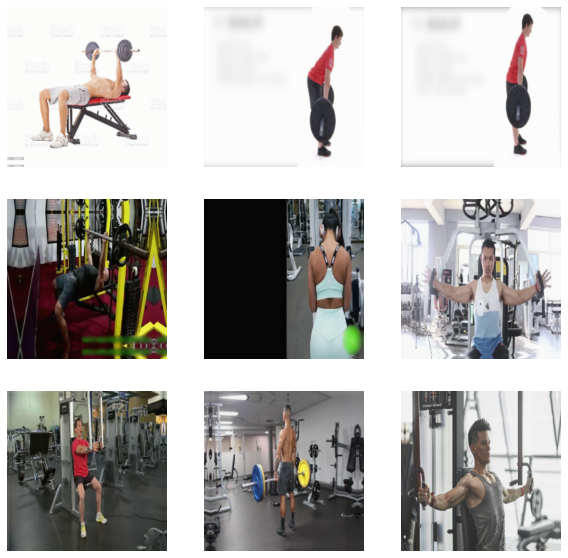

In [5]:
#Defing a function to see images
def show_img(data):
    plt.figure(figsize=(10,10))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset
show_img(train_ds)

# Create, Compile, Train, and Evaluate The Model

In [6]:
# load pre-trained InceptionV3
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

for layer in pre_trained.layers:
    layer.trainable = False

87924736/87910968 [==============================] - 0s 0us/step


In [7]:
x = pre_trained.output
x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
predictions = tf.keras.layers.Dense(len(labels), activation='softmax')(x)

workout_model = tf.keras.models.Model(inputs = pre_trained.input, 
                                      outputs = predictions
                                     )

workout_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy']
                     )

workout_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Train Model

In [8]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', 
                                        patience = 5, 
                                        mode = 'min', 
                                        restore_best_weights = True
                                       )

history = workout_model.fit(train_ds,
                            validation_data = val_ds,
                            epochs = 100,
                            callbacks = [early_stopping_callback]
                           )

Epoch 1/100


2022-06-10 06:46:48.658448: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


31/31 [==============================] - 37s 826ms/step - loss: 1.7397 - accuracy: 0.3862 - val_loss: 1.6433 - val_accuracy: 0.3624
Epoch 2/100
31/31 [==============================] - 24s 749ms/step - loss: 1.2114 - accuracy: 0.6047 - val_loss: 1.2249 - val_accuracy: 0.5367
Epoch 3/100
31/31 [==============================] - 24s 739ms/step - loss: 0.9705 - accuracy: 0.6982 - val_loss: 0.8753 - val_accuracy: 0.7431
Epoch 4/100
31/31 [==============================] - 24s 740ms/step - loss: 0.8258 - accuracy: 0.7388 - val_loss: 0.7751 - val_accuracy: 0.7890
Epoch 5/100
31/31 [==============================] - 24s 730ms/step - loss: 0.7227 - accuracy: 0.7729 - val_loss: 0.6319 - val_accuracy: 0.8119
Epoch 6/100
31/31 [==============================] - 24s 750ms/step - loss: 0.6155 - accuracy: 0.8074 - val_loss: 0.5728 - val_accuracy: 0.8578
Epoch 7/100
31/31 [==============================] - 24s 747ms/step - loss: 0.5370 - accuracy: 0.8354 - val_loss: 0.4799 - val_accuracy: 0.8761
Epoc

## Evaluate Model

4/4 [==============================] - 1s 112ms/step - loss: 0.2006 - accuracy: 0.9541


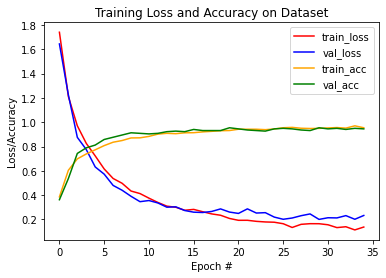

In [9]:
evaluate = workout_model.evaluate(val_ds)

epoch = range(len(history.history["loss"]))
plt.figure()
plt.plot(epoch, history.history['loss'], 'red', label = 'train_loss')
plt.plot(epoch, history.history['val_loss'], 'blue', label = 'val_loss')
plt.plot(epoch, history.history['accuracy'], 'orange', label = 'train_acc')
plt.plot(epoch, history.history['val_accuracy'], 'green', label = 'val_acc')
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# Save and Test The Model to Predict Video

In [10]:
# Save Model
workout_model.save('workout_model')

# Save .h5 model
workout_model.save('workout_model.h5')

# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_saved_model('./workout_model')
tflite_model = converter.convert()

# Save the tflite model
with open('workout_model.tflite', 'wb') as f:
    f.write(tflite_model)

2022-06-10 07:01:35.672835: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-06-10 07:02:14.160679: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2022-06-10 07:02:14.160742: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
2022-06-10 07:02:14.160753: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored change_concat_input_ranges.
2022-06-10 07:02:14.161654: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: ./workout_model
2022-06-10 07:02:14.235547: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2022-06-10 07:02:14.235594: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: ./workout_model
2022-06-10 07:02:14.583717: I tensorflow/cc/saved_model/loader.cc:229]

Deadlift/deadlift_1.mp4
activity:deadlift
confidence: 0.9948855042457581


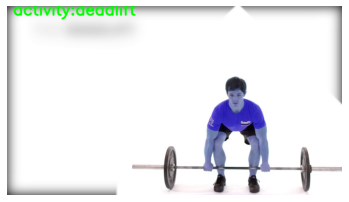

In [11]:
random_classes_names = random.choice(os.listdir('../input/workoutfitness-video/workout'))
random_file = random.choice(os.listdir(f'../input/workoutfitness-video/workout/{random_classes_names}'))
print(f'{random_classes_names}/{random_file}')

# Construct the input video file path
input_video_file_path = f'../input/workoutfitness-video/workout/{random_classes_names}/{random_file}'

# Initialize video input
video_capture = cv2.VideoCapture(input_video_file_path)
writer = None
H, W = None, None
Q = deque(maxlen=128)
n = 0

# Loop through each frame in the video
while True:
    # count the frame
    n += 1
    
    # predict every 5 frame (1, 6, 11, ... etc)
    if n % 5 != 1:
        continue
    
    # read a frame
    success, frame = video_capture.read()
    
    # if frame not read properly then break the loop
    if not success:
        break
    
    # get frame dimensions
    if W is None or H is None:
        (H, W) = frame.shape[:2]
    
    # clone the frame for the output then preprocess the frame for the prediction
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, img_size).astype("float32")
        
    predictions = workout_model.predict(np.expand_dims(frame, axis=0))[0]
    Q.append(predictions)
    
    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = labels[i]
    
    text = 'activity:{}'.format(label)
    cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 10)
    
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"XVID")
        writer = cv2.VideoWriter('output.avi', fourcc, 30, (W, H), True)
        
    writer.write(output)
    
    plt.imshow(output)
    plt.axis('off')
    
    # break the loop if prediction > 90% and video already more than 2 seconds (60 frame)
    if results[i] >= 0.9 and n >= 60:
        break

print(text)
print(f'confidence: {results[i]}')
writer.release()
video_capture.release()